##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

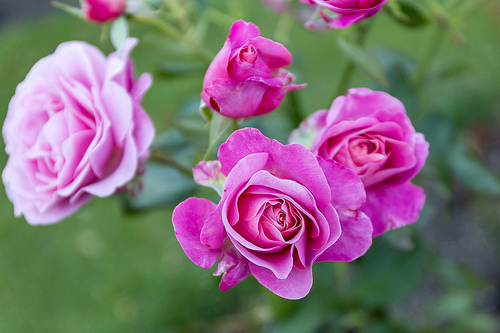

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

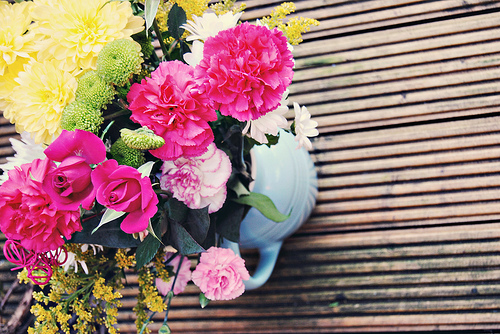

In [6]:
PIL.Image.open(str(roses[1]))

And some tulips:

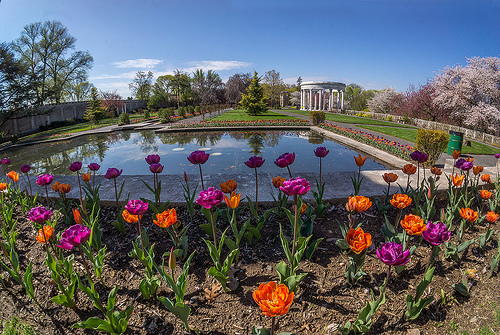

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

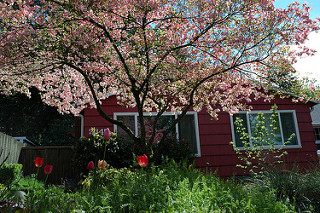

In [8]:
PIL.Image.open(str(tulips[1]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first 9 images from the training dataset.

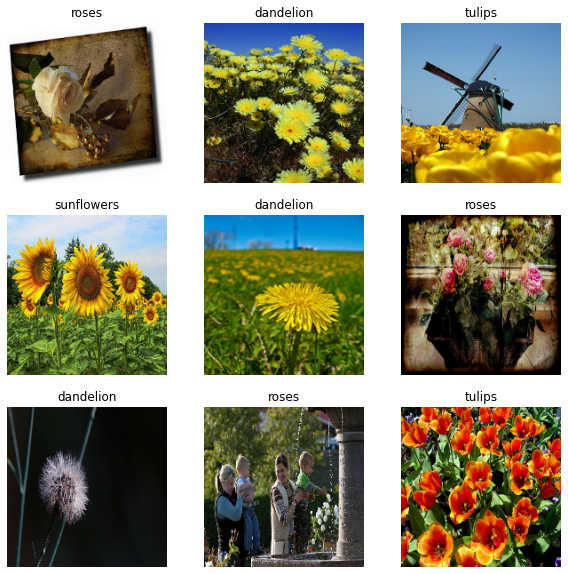

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [18]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train the model

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


 1/92 [..............................] - ETA: 3:00 - loss: 1.6002 - accuracy: 0.2500

 7/92 [=>............................] - ETA: 0s - loss: 1.7938 - accuracy: 0.2277  

13/92 [===>..........................] - ETA: 0s - loss: 1.6478 - accuracy: 0.2788

19/92 [=====>........................] - ETA: 0s - loss: 1.5779 - accuracy: 0.3026

26/92 [=======>......................] - ETA: 0s - loss: 1.5033 - accuracy: 0.3293

32/92 [=========>....................] - ETA: 0s - loss: 1.4640 - accuracy: 0.3594

39/92 [===========>..................] - ETA: 0s - loss: 1.4279 - accuracy: 0.3758

45/92 [=============>................] - ETA: 0s - loss: 1.4098 - accuracy: 0.3826

51/92 [===============>..............] - ETA: 0s - loss: 1.3839 - accuracy: 0.3928

58/92 [=================>............] - ETA: 0s - loss: 1.3536 - accuracy: 0.4068

64/92 [===================>..........] - ETA: 0s - loss: 1.3314 - accuracy: 0.4136

70/92 [=====================>........] - ETA: 0s - loss: 1.3113 - accuracy: 0.4219

77/92 [========================>.....] - ETA: 0s - loss: 1.2868 - accuracy: 0.4347

80/92 [=========================>....] - ETA: 0s - loss: 1.2787 - accuracy: 0.4393

86/92 [===========================>..] - ETA: 0s - loss: 1.2750 - accuracy: 0.4439

92/92 [==============================] - 4s 17ms/step - loss: 1.2628 - accuracy: 0.4537 - val_loss: 1.1074 - val_accuracy: 0.5572


Epoch 2/10
 1/92 [..............................] - ETA: 0s - loss: 1.0487 - accuracy: 0.6250

 7/92 [=>............................] - ETA: 0s - loss: 1.1139 - accuracy: 0.5759

13/92 [===>..........................] - ETA: 0s - loss: 1.0741 - accuracy: 0.5817

19/92 [=====>........................] - ETA: 0s - loss: 1.0224 - accuracy: 0.6003

25/92 [=======>......................] - ETA: 0s - loss: 1.0219 - accuracy: 0.5987

31/92 [=========>....................] - ETA: 0s - loss: 1.0064 - accuracy: 0.6087

38/92 [===========>..................] - ETA: 0s - loss: 1.0002 - accuracy: 0.6093

44/92 [=============>................] - ETA: 0s - loss: 0.9952 - accuracy: 0.6107

50/92 [===============>..............] - ETA: 0s - loss: 0.9856 - accuracy: 0.6162

56/92 [=================>............] - ETA: 0s - loss: 0.9783 - accuracy: 0.6200

63/92 [===================>..........] - ETA: 0s - loss: 0.9683 - accuracy: 0.6225

69/92 [=====================>........] - ETA: 0s - loss: 0.9613 - accuracy: 0.6291

75/92 [=======================>......] - ETA: 0s - loss: 0.9587 - accuracy: 0.6292

81/92 [=========================>....] - ETA: 0s - loss: 0.9551 - accuracy: 0.6289

87/92 [===========================>..] - ETA: 0s - loss: 0.9510 - accuracy: 0.6311

92/92 [==============================] - 1s 10ms/step - loss: 0.9579 - accuracy: 0.6294 - val_loss: 0.9262 - val_accuracy: 0.6308


Epoch 3/10
 1/92 [..............................] - ETA: 0s - loss: 1.0627 - accuracy: 0.7500

 8/92 [=>............................] - ETA: 0s - loss: 0.7981 - accuracy: 0.7148

14/92 [===>..........................] - ETA: 0s - loss: 0.7925 - accuracy: 0.7121

20/92 [=====>........................] - ETA: 0s - loss: 0.7833 - accuracy: 0.7156

27/92 [=======>......................] - ETA: 0s - loss: 0.7801 - accuracy: 0.7106

33/92 [=========>....................] - ETA: 0s - loss: 0.7798 - accuracy: 0.7093

39/92 [===========>..................] - ETA: 0s - loss: 0.7765 - accuracy: 0.7099

46/92 [==============>...............] - ETA: 0s - loss: 0.7727 - accuracy: 0.7126

52/92 [===============>..............] - ETA: 0s - loss: 0.7780 - accuracy: 0.7120

58/92 [=================>............] - ETA: 0s - loss: 0.7819 - accuracy: 0.7083

65/92 [====================>.........] - ETA: 0s - loss: 0.7757 - accuracy: 0.7114

71/92 [======================>.......] - ETA: 0s - loss: 0.7814 - accuracy: 0.7098

78/92 [========================>.....] - ETA: 0s - loss: 0.7788 - accuracy: 0.7086

84/92 [==========================>...] - ETA: 0s - loss: 0.7751 - accuracy: 0.7112

91/92 [============================>.] - ETA: 0s - loss: 0.7728 - accuracy: 0.7114

92/92 [==============================] - 1s 10ms/step - loss: 0.7716 - accuracy: 0.7125 - val_loss: 0.8882 - val_accuracy: 0.6417


Epoch 4/10
 1/92 [..............................] - ETA: 0s - loss: 0.6571 - accuracy: 0.6875

 7/92 [=>............................] - ETA: 0s - loss: 0.6634 - accuracy: 0.7589

13/92 [===>..........................] - ETA: 0s - loss: 0.6319 - accuracy: 0.7788

20/92 [=====>........................] - ETA: 0s - loss: 0.6043 - accuracy: 0.7828

26/92 [=======>......................] - ETA: 0s - loss: 0.6104 - accuracy: 0.7803

32/92 [=========>....................] - ETA: 0s - loss: 0.6286 - accuracy: 0.7677

38/92 [===========>..................] - ETA: 0s - loss: 0.6136 - accuracy: 0.7790

45/92 [=============>................] - ETA: 0s - loss: 0.6025 - accuracy: 0.7835

51/92 [===============>..............] - ETA: 0s - loss: 0.6073 - accuracy: 0.7796

58/92 [=================>............] - ETA: 0s - loss: 0.6016 - accuracy: 0.7798

64/92 [===================>..........] - ETA: 0s - loss: 0.5995 - accuracy: 0.7779

70/92 [=====================>........] - ETA: 0s - loss: 0.6012 - accuracy: 0.7769

77/92 [========================>.....] - ETA: 0s - loss: 0.5988 - accuracy: 0.7781

84/92 [==========================>...] - ETA: 0s - loss: 0.5902 - accuracy: 0.7802

90/92 [============================>.] - ETA: 0s - loss: 0.5855 - accuracy: 0.7820

92/92 [==============================] - 1s 10ms/step - loss: 0.5841 - accuracy: 0.7817 - val_loss: 0.9509 - val_accuracy: 0.6335


Epoch 5/10
 1/92 [..............................] - ETA: 0s - loss: 0.2861 - accuracy: 0.9688

 7/92 [=>............................] - ETA: 0s - loss: 0.4861 - accuracy: 0.8482

13/92 [===>..........................] - ETA: 0s - loss: 0.4757 - accuracy: 0.8438

19/92 [=====>........................] - ETA: 0s - loss: 0.4349 - accuracy: 0.8586

26/92 [=======>......................] - ETA: 0s - loss: 0.3889 - accuracy: 0.8750

32/92 [=========>....................] - ETA: 0s - loss: 0.3739 - accuracy: 0.8770

38/92 [===========>..................] - ETA: 0s - loss: 0.3654 - accuracy: 0.8808

44/92 [=============>................] - ETA: 0s - loss: 0.3602 - accuracy: 0.8814

51/92 [===============>..............] - ETA: 0s - loss: 0.3591 - accuracy: 0.8824

57/92 [=================>............] - ETA: 0s - loss: 0.3586 - accuracy: 0.8822

63/92 [===================>..........] - ETA: 0s - loss: 0.3514 - accuracy: 0.8845

69/92 [=====================>........] - ETA: 0s - loss: 0.3524 - accuracy: 0.8823

75/92 [=======================>......] - ETA: 0s - loss: 0.3490 - accuracy: 0.8834

82/92 [=========================>....] - ETA: 0s - loss: 0.3461 - accuracy: 0.8842

89/92 [============================>.] - ETA: 0s - loss: 0.3478 - accuracy: 0.8835

92/92 [==============================] - 1s 10ms/step - loss: 0.3462 - accuracy: 0.8832 - val_loss: 1.2011 - val_accuracy: 0.6349


Epoch 6/10
 1/92 [..............................] - ETA: 0s - loss: 0.1257 - accuracy: 0.9688

 7/92 [=>............................] - ETA: 0s - loss: 0.1284 - accuracy: 0.9732

14/92 [===>..........................] - ETA: 0s - loss: 0.1910 - accuracy: 0.9464

20/92 [=====>........................] - ETA: 0s - loss: 0.1921 - accuracy: 0.9469

26/92 [=======>......................] - ETA: 0s - loss: 0.1941 - accuracy: 0.9447

32/92 [=========>....................] - ETA: 0s - loss: 0.2214 - accuracy: 0.9365

38/92 [===========>..................] - ETA: 0s - loss: 0.2151 - accuracy: 0.9391

44/92 [=============>................] - ETA: 0s - loss: 0.2219 - accuracy: 0.9371

50/92 [===============>..............] - ETA: 0s - loss: 0.2199 - accuracy: 0.9372

56/92 [=================>............] - ETA: 0s - loss: 0.2220 - accuracy: 0.9350

63/92 [===================>..........] - ETA: 0s - loss: 0.2257 - accuracy: 0.9333

69/92 [=====================>........] - ETA: 0s - loss: 0.2209 - accuracy: 0.9332

75/92 [=======================>......] - ETA: 0s - loss: 0.2211 - accuracy: 0.9331

81/92 [=========================>....] - ETA: 0s - loss: 0.2218 - accuracy: 0.9334

88/92 [===========================>..] - ETA: 0s - loss: 0.2173 - accuracy: 0.9352

92/92 [==============================] - 1s 10ms/step - loss: 0.2152 - accuracy: 0.9349 - val_loss: 1.1848 - val_accuracy: 0.6444


Epoch 7/10
 1/92 [..............................] - ETA: 0s - loss: 0.0940 - accuracy: 0.9688

 7/92 [=>............................] - ETA: 0s - loss: 0.0990 - accuracy: 0.9688

13/92 [===>..........................] - ETA: 0s - loss: 0.1079 - accuracy: 0.9688

19/92 [=====>........................] - ETA: 0s - loss: 0.1034 - accuracy: 0.9704

26/92 [=======>......................] - ETA: 0s - loss: 0.0911 - accuracy: 0.9760

33/92 [=========>....................] - ETA: 0s - loss: 0.0903 - accuracy: 0.9744

39/92 [===========>..................] - ETA: 0s - loss: 0.0905 - accuracy: 0.9728

45/92 [=============>................] - ETA: 0s - loss: 0.0990 - accuracy: 0.9708

52/92 [===============>..............] - ETA: 0s - loss: 0.1059 - accuracy: 0.9706

58/92 [=================>............] - ETA: 0s - loss: 0.1086 - accuracy: 0.9693

64/92 [===================>..........] - ETA: 0s - loss: 0.1057 - accuracy: 0.9697

71/92 [======================>.......] - ETA: 0s - loss: 0.1071 - accuracy: 0.9679

77/92 [========================>.....] - ETA: 0s - loss: 0.1060 - accuracy: 0.9683

83/92 [==========================>...] - ETA: 0s - loss: 0.1111 - accuracy: 0.9668

90/92 [============================>.] - ETA: 0s - loss: 0.1156 - accuracy: 0.9634

92/92 [==============================] - 1s 10ms/step - loss: 0.1151 - accuracy: 0.9636 - val_loss: 1.3885 - val_accuracy: 0.6444


Epoch 8/10
 1/92 [..............................] - ETA: 0s - loss: 0.0438 - accuracy: 1.0000

 7/92 [=>............................] - ETA: 0s - loss: 0.0643 - accuracy: 0.9821

14/92 [===>..........................] - ETA: 0s - loss: 0.0871 - accuracy: 0.9777

20/92 [=====>........................] - ETA: 0s - loss: 0.0931 - accuracy: 0.9703

26/92 [=======>......................] - ETA: 0s - loss: 0.0856 - accuracy: 0.9760

33/92 [=========>....................] - ETA: 0s - loss: 0.0772 - accuracy: 0.9801

39/92 [===========>..................] - ETA: 0s - loss: 0.0733 - accuracy: 0.9824

46/92 [==============>...............] - ETA: 0s - loss: 0.0689 - accuracy: 0.9837

53/92 [================>.............] - ETA: 0s - loss: 0.0669 - accuracy: 0.9841

59/92 [==================>...........] - ETA: 0s - loss: 0.0654 - accuracy: 0.9846

65/92 [====================>.........] - ETA: 0s - loss: 0.0637 - accuracy: 0.9846

71/92 [======================>.......] - ETA: 0s - loss: 0.0624 - accuracy: 0.9854

77/92 [========================>.....] - ETA: 0s - loss: 0.0592 - accuracy: 0.9866

83/92 [==========================>...] - ETA: 0s - loss: 0.0592 - accuracy: 0.9864

89/92 [============================>.] - ETA: 0s - loss: 0.0609 - accuracy: 0.9852

92/92 [==============================] - 1s 10ms/step - loss: 0.0608 - accuracy: 0.9854 - val_loss: 1.9407 - val_accuracy: 0.6499


Epoch 9/10
 1/92 [..............................] - ETA: 0s - loss: 0.0767 - accuracy: 0.9688

 7/92 [=>............................] - ETA: 0s - loss: 0.0706 - accuracy: 0.9643

13/92 [===>..........................] - ETA: 0s - loss: 0.0673 - accuracy: 0.9736

19/92 [=====>........................] - ETA: 0s - loss: 0.0858 - accuracy: 0.9753

25/92 [=======>......................] - ETA: 0s - loss: 0.0824 - accuracy: 0.9762

31/92 [=========>....................] - ETA: 0s - loss: 0.0842 - accuracy: 0.9768

37/92 [===========>..................] - ETA: 0s - loss: 0.0813 - accuracy: 0.9780

43/92 [=============>................] - ETA: 0s - loss: 0.0736 - accuracy: 0.9804

49/92 [==============>...............] - ETA: 0s - loss: 0.0728 - accuracy: 0.9802

55/92 [================>.............] - ETA: 0s - loss: 0.0700 - accuracy: 0.9812

61/92 [==================>...........] - ETA: 0s - loss: 0.0673 - accuracy: 0.9830

67/92 [====================>.........] - ETA: 0s - loss: 0.0649 - accuracy: 0.9836

73/92 [======================>.......] - ETA: 0s - loss: 0.0643 - accuracy: 0.9837

79/92 [========================>.....] - ETA: 0s - loss: 0.0622 - accuracy: 0.9849

85/92 [==========================>...] - ETA: 0s - loss: 0.0619 - accuracy: 0.9838

91/92 [============================>.] - ETA: 0s - loss: 0.0627 - accuracy: 0.9831

92/92 [==============================] - 1s 10ms/step - loss: 0.0634 - accuracy: 0.9826 - val_loss: 1.9400 - val_accuracy: 0.6444


Epoch 10/10
 1/92 [..............................] - ETA: 0s - loss: 0.4077 - accuracy: 0.9375

 7/92 [=>............................] - ETA: 0s - loss: 0.1219 - accuracy: 0.9777

13/92 [===>..........................] - ETA: 0s - loss: 0.1226 - accuracy: 0.9688

19/92 [=====>........................] - ETA: 0s - loss: 0.0959 - accuracy: 0.9753

25/92 [=======>......................] - ETA: 0s - loss: 0.0876 - accuracy: 0.9747

31/92 [=========>....................] - ETA: 0s - loss: 0.0790 - accuracy: 0.9776

37/92 [===========>..................] - ETA: 0s - loss: 0.0714 - accuracy: 0.9813

43/92 [=============>................] - ETA: 0s - loss: 0.0661 - accuracy: 0.9832

49/92 [==============>...............] - ETA: 0s - loss: 0.0628 - accuracy: 0.9840

55/92 [================>.............] - ETA: 0s - loss: 0.0607 - accuracy: 0.9846

61/92 [==================>...........] - ETA: 0s - loss: 0.0567 - accuracy: 0.9861

67/92 [====================>.........] - ETA: 0s - loss: 0.0524 - accuracy: 0.9874

73/92 [======================>.......] - ETA: 0s - loss: 0.0516 - accuracy: 0.9871

79/92 [========================>.....] - ETA: 0s - loss: 0.0494 - accuracy: 0.9873

85/92 [==========================>...] - ETA: 0s - loss: 0.0478 - accuracy: 0.9878

91/92 [============================>.] - ETA: 0s - loss: 0.0464 - accuracy: 0.9883

92/92 [==============================] - 1s 10ms/step - loss: 0.0464 - accuracy: 0.9881 - val_loss: 2.0665 - val_accuracy: 0.6376


## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

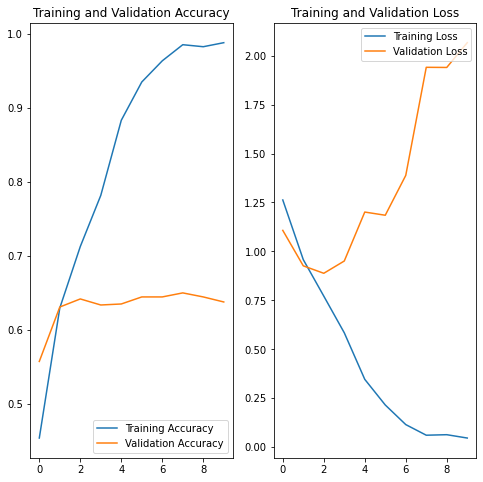

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

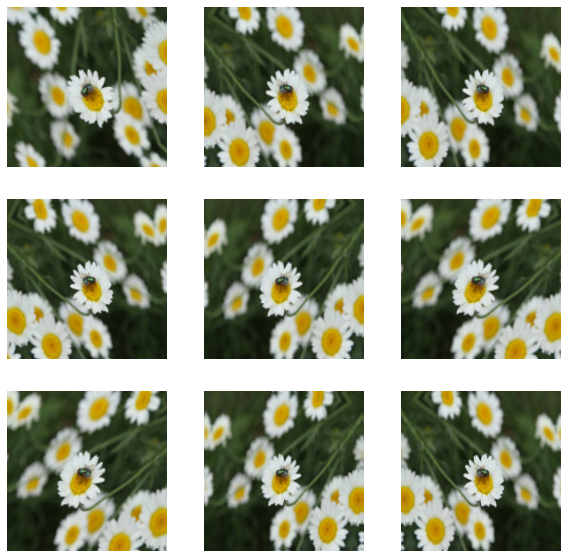

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [25]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


 1/92 [..............................] - ETA: 1:03 - loss: 1.6466 - accuracy: 0.1250

 7/92 [=>............................] - ETA: 0s - loss: 2.1877 - accuracy: 0.2188  

13/92 [===>..........................] - ETA: 0s - loss: 1.9214 - accuracy: 0.1995

19/92 [=====>........................] - ETA: 0s - loss: 1.8202 - accuracy: 0.2188

25/92 [=======>......................] - ETA: 0s - loss: 1.7715 - accuracy: 0.2200

31/92 [=========>....................] - ETA: 0s - loss: 1.7341 - accuracy: 0.2358

37/92 [===========>..................] - ETA: 0s - loss: 1.6964 - accuracy: 0.2509

43/92 [=============>................] - ETA: 0s - loss: 1.6688 - accuracy: 0.2639

49/92 [==============>...............] - ETA: 0s - loss: 1.6481 - accuracy: 0.2679

55/92 [================>.............] - ETA: 0s - loss: 1.6245 - accuracy: 0.2803

61/92 [==================>...........] - ETA: 0s - loss: 1.6125 - accuracy: 0.2814

67/92 [====================>.........] - ETA: 0s - loss: 1.5899 - accuracy: 0.2893

73/92 [======================>.......] - ETA: 0s - loss: 1.5686 - accuracy: 0.2985

79/92 [========================>.....] - ETA: 0s - loss: 1.5534 - accuracy: 0.3060

85/92 [==========================>...] - ETA: 0s - loss: 1.5308 - accuracy: 0.3178

91/92 [============================>.] - ETA: 0s - loss: 1.5041 - accuracy: 0.3320

92/92 [==============================] - 2s 14ms/step - loss: 1.4997 - accuracy: 0.3345 - val_loss: 1.2243 - val_accuracy: 0.4959


Epoch 2/15
 1/92 [..............................] - ETA: 0s - loss: 1.2477 - accuracy: 0.4375

 7/92 [=>............................] - ETA: 0s - loss: 1.2364 - accuracy: 0.4583

13/92 [===>..........................] - ETA: 0s - loss: 1.2340 - accuracy: 0.4730

19/92 [=====>........................] - ETA: 0s - loss: 1.2262 - accuracy: 0.4700

25/92 [=======>......................] - ETA: 0s - loss: 1.2218 - accuracy: 0.4747

31/92 [=========>....................] - ETA: 0s - loss: 1.2294 - accuracy: 0.4797

37/92 [===========>..................] - ETA: 0s - loss: 1.2263 - accuracy: 0.4855

43/92 [=============>................] - ETA: 0s - loss: 1.2116 - accuracy: 0.4905

49/92 [==============>...............] - ETA: 0s - loss: 1.1941 - accuracy: 0.4994

55/92 [================>.............] - ETA: 0s - loss: 1.1868 - accuracy: 0.5017

61/92 [==================>...........] - ETA: 0s - loss: 1.1812 - accuracy: 0.5036

67/92 [====================>.........] - ETA: 0s - loss: 1.1769 - accuracy: 0.5061

71/92 [======================>.......] - ETA: 0s - loss: 1.1724 - accuracy: 0.5088

77/92 [========================>.....] - ETA: 0s - loss: 1.1695 - accuracy: 0.5106

83/92 [==========================>...] - ETA: 0s - loss: 1.1585 - accuracy: 0.5159

89/92 [============================>.] - ETA: 0s - loss: 1.1569 - accuracy: 0.5173

92/92 [==============================] - 1s 11ms/step - loss: 1.1559 - accuracy: 0.5215 - val_loss: 1.1232 - val_accuracy: 0.5804


Epoch 3/15
 1/92 [..............................] - ETA: 0s - loss: 1.4348 - accuracy: 0.4375

 7/92 [=>............................] - ETA: 0s - loss: 1.1324 - accuracy: 0.5446

13/92 [===>..........................] - ETA: 0s - loss: 1.1073 - accuracy: 0.5457

19/92 [=====>........................] - ETA: 0s - loss: 1.0672 - accuracy: 0.5674

25/92 [=======>......................] - ETA: 0s - loss: 1.0513 - accuracy: 0.5838

31/92 [=========>....................] - ETA: 0s - loss: 1.0261 - accuracy: 0.5988

37/92 [===========>..................] - ETA: 0s - loss: 1.0405 - accuracy: 0.5895

43/92 [=============>................] - ETA: 0s - loss: 1.0226 - accuracy: 0.6032

49/92 [==============>...............] - ETA: 0s - loss: 1.0238 - accuracy: 0.5969

55/92 [================>.............] - ETA: 0s - loss: 1.0244 - accuracy: 0.5989

61/92 [==================>...........] - ETA: 0s - loss: 1.0323 - accuracy: 0.5922

67/92 [====================>.........] - ETA: 0s - loss: 1.0205 - accuracy: 0.5961

73/92 [======================>.......] - ETA: 0s - loss: 1.0131 - accuracy: 0.5997

79/92 [========================>.....] - ETA: 0s - loss: 1.0153 - accuracy: 0.5996

85/92 [==========================>...] - ETA: 0s - loss: 1.0188 - accuracy: 0.5996

91/92 [============================>.] - ETA: 0s - loss: 1.0147 - accuracy: 0.6023

92/92 [==============================] - 1s 11ms/step - loss: 1.0131 - accuracy: 0.6029 - val_loss: 0.9819 - val_accuracy: 0.6022


Epoch 4/15
 1/92 [..............................] - ETA: 0s - loss: 0.8594 - accuracy: 0.6875

 7/92 [=>............................] - ETA: 0s - loss: 0.9068 - accuracy: 0.6518

13/92 [===>..........................] - ETA: 0s - loss: 0.8882 - accuracy: 0.6731

19/92 [=====>........................] - ETA: 0s - loss: 0.9692 - accuracy: 0.6398

25/92 [=======>......................] - ETA: 0s - loss: 0.9433 - accuracy: 0.6575

31/92 [=========>....................] - ETA: 0s - loss: 0.9440 - accuracy: 0.6492

37/92 [===========>..................] - ETA: 0s - loss: 0.9480 - accuracy: 0.6470

43/92 [=============>................] - ETA: 0s - loss: 0.9435 - accuracy: 0.6453

49/92 [==============>...............] - ETA: 0s - loss: 0.9499 - accuracy: 0.6429

55/92 [================>.............] - ETA: 0s - loss: 0.9513 - accuracy: 0.6409

61/92 [==================>...........] - ETA: 0s - loss: 0.9501 - accuracy: 0.6404

67/92 [====================>.........] - ETA: 0s - loss: 0.9452 - accuracy: 0.6423

73/92 [======================>.......] - ETA: 0s - loss: 0.9451 - accuracy: 0.6417

79/92 [========================>.....] - ETA: 0s - loss: 0.9445 - accuracy: 0.6409

85/92 [==========================>...] - ETA: 0s - loss: 0.9413 - accuracy: 0.6394

91/92 [============================>.] - ETA: 0s - loss: 0.9473 - accuracy: 0.6357

92/92 [==============================] - 1s 11ms/step - loss: 0.9482 - accuracy: 0.6352 - val_loss: 0.9013 - val_accuracy: 0.6294


Epoch 5/15
 1/92 [..............................] - ETA: 0s - loss: 0.8465 - accuracy: 0.6875

 7/92 [=>............................] - ETA: 0s - loss: 0.8018 - accuracy: 0.6875

13/92 [===>..........................] - ETA: 0s - loss: 0.8534 - accuracy: 0.6875

19/92 [=====>........................] - ETA: 0s - loss: 0.8460 - accuracy: 0.6891

25/92 [=======>......................] - ETA: 0s - loss: 0.8554 - accuracy: 0.6850

31/92 [=========>....................] - ETA: 0s - loss: 0.8590 - accuracy: 0.6744

37/92 [===========>..................] - ETA: 0s - loss: 0.8796 - accuracy: 0.6672

43/92 [=============>................] - ETA: 0s - loss: 0.8848 - accuracy: 0.6701

49/92 [==============>...............] - ETA: 0s - loss: 0.8860 - accuracy: 0.6684

55/92 [================>.............] - ETA: 0s - loss: 0.8739 - accuracy: 0.6739

61/92 [==================>...........] - ETA: 0s - loss: 0.8909 - accuracy: 0.6696

67/92 [====================>.........] - ETA: 0s - loss: 0.8910 - accuracy: 0.6693

73/92 [======================>.......] - ETA: 0s - loss: 0.8875 - accuracy: 0.6671

78/92 [========================>.....] - ETA: 0s - loss: 0.8916 - accuracy: 0.6648

81/92 [=========================>....] - ETA: 0s - loss: 0.8861 - accuracy: 0.6660

85/92 [==========================>...] - ETA: 0s - loss: 0.8821 - accuracy: 0.6674

89/92 [============================>.] - ETA: 0s - loss: 0.8810 - accuracy: 0.6683

92/92 [==============================] - ETA: 0s - loss: 0.8831 - accuracy: 0.6655

92/92 [==============================] - 1s 13ms/step - loss: 0.8831 - accuracy: 0.6655 - val_loss: 0.9165 - val_accuracy: 0.6362


Epoch 6/15
 1/92 [..............................] - ETA: 1s - loss: 0.9604 - accuracy: 0.6250

 5/92 [>.............................] - ETA: 1s - loss: 0.8860 - accuracy: 0.6750

10/92 [==>...........................] - ETA: 1s - loss: 0.7972 - accuracy: 0.7219

16/92 [====>.........................] - ETA: 0s - loss: 0.8050 - accuracy: 0.7207

22/92 [======>.......................] - ETA: 0s - loss: 0.8242 - accuracy: 0.7145

28/92 [========>.....................] - ETA: 0s - loss: 0.8142 - accuracy: 0.7087

34/92 [==========>...................] - ETA: 0s - loss: 0.7979 - accuracy: 0.7022

40/92 [============>.................] - ETA: 0s - loss: 0.8105 - accuracy: 0.6953

46/92 [==============>...............] - ETA: 0s - loss: 0.8164 - accuracy: 0.6895

52/92 [===============>..............] - ETA: 0s - loss: 0.8203 - accuracy: 0.6881

58/92 [=================>............] - ETA: 0s - loss: 0.8144 - accuracy: 0.6945

64/92 [===================>..........] - ETA: 0s - loss: 0.8176 - accuracy: 0.6968

70/92 [=====================>........] - ETA: 0s - loss: 0.8207 - accuracy: 0.6962

76/92 [=======================>......] - ETA: 0s - loss: 0.8238 - accuracy: 0.6947

82/92 [=========================>....] - ETA: 0s - loss: 0.8224 - accuracy: 0.6934

88/92 [===========================>..] - ETA: 0s - loss: 0.8270 - accuracy: 0.6902

92/92 [==============================] - 1s 12ms/step - loss: 0.8271 - accuracy: 0.6880 - val_loss: 0.8330 - val_accuracy: 0.6880


Epoch 7/15
 1/92 [..............................] - ETA: 0s - loss: 0.6560 - accuracy: 0.8438

 7/92 [=>............................] - ETA: 0s - loss: 0.8737 - accuracy: 0.6806

13/92 [===>..........................] - ETA: 0s - loss: 0.8253 - accuracy: 0.7010

19/92 [=====>........................] - ETA: 0s - loss: 0.8219 - accuracy: 0.6900

25/92 [=======>......................] - ETA: 0s - loss: 0.7922 - accuracy: 0.6957

31/92 [=========>....................] - ETA: 0s - loss: 0.7847 - accuracy: 0.7043

37/92 [===========>..................] - ETA: 0s - loss: 0.7917 - accuracy: 0.6964

43/92 [=============>................] - ETA: 0s - loss: 0.7936 - accuracy: 0.6959

49/92 [==============>...............] - ETA: 0s - loss: 0.7851 - accuracy: 0.6968

55/92 [================>.............] - ETA: 0s - loss: 0.7747 - accuracy: 0.7021

61/92 [==================>...........] - ETA: 0s - loss: 0.7771 - accuracy: 0.6991

67/92 [====================>.........] - ETA: 0s - loss: 0.7783 - accuracy: 0.6980

73/92 [======================>.......] - ETA: 0s - loss: 0.7684 - accuracy: 0.7032

79/92 [========================>.....] - ETA: 0s - loss: 0.7723 - accuracy: 0.7016

85/92 [==========================>...] - ETA: 0s - loss: 0.7784 - accuracy: 0.6973

91/92 [============================>.] - ETA: 0s - loss: 0.7801 - accuracy: 0.6956

92/92 [==============================] - 1s 11ms/step - loss: 0.7858 - accuracy: 0.6924 - val_loss: 0.9185 - val_accuracy: 0.6499


Epoch 8/15
 1/92 [..............................] - ETA: 0s - loss: 0.6993 - accuracy: 0.7188

 7/92 [=>............................] - ETA: 0s - loss: 0.7748 - accuracy: 0.7054

13/92 [===>..........................] - ETA: 0s - loss: 0.7695 - accuracy: 0.7139

19/92 [=====>........................] - ETA: 0s - loss: 0.7768 - accuracy: 0.7138

25/92 [=======>......................] - ETA: 0s - loss: 0.7981 - accuracy: 0.7063

31/92 [=========>....................] - ETA: 0s - loss: 0.7863 - accuracy: 0.7147

37/92 [===========>..................] - ETA: 0s - loss: 0.7677 - accuracy: 0.7145

43/92 [=============>................] - ETA: 0s - loss: 0.7517 - accuracy: 0.7180

49/92 [==============>...............] - ETA: 0s - loss: 0.7492 - accuracy: 0.7219

55/92 [================>.............] - ETA: 0s - loss: 0.7546 - accuracy: 0.7170

61/92 [==================>...........] - ETA: 0s - loss: 0.7570 - accuracy: 0.7177

67/92 [====================>.........] - ETA: 0s - loss: 0.7553 - accuracy: 0.7169

73/92 [======================>.......] - ETA: 0s - loss: 0.7524 - accuracy: 0.7179

79/92 [========================>.....] - ETA: 0s - loss: 0.7547 - accuracy: 0.7188

85/92 [==========================>...] - ETA: 0s - loss: 0.7592 - accuracy: 0.7184

91/92 [============================>.] - ETA: 0s - loss: 0.7625 - accuracy: 0.7152

92/92 [==============================] - 1s 11ms/step - loss: 0.7602 - accuracy: 0.7166 - val_loss: 0.8225 - val_accuracy: 0.6771


Epoch 9/15
 1/92 [..............................] - ETA: 0s - loss: 0.8854 - accuracy: 0.6562

 7/92 [=>............................] - ETA: 0s - loss: 0.7645 - accuracy: 0.7188

13/92 [===>..........................] - ETA: 0s - loss: 0.7761 - accuracy: 0.7091

19/92 [=====>........................] - ETA: 0s - loss: 0.7351 - accuracy: 0.7303

25/92 [=======>......................] - ETA: 0s - loss: 0.7291 - accuracy: 0.7287

31/92 [=========>....................] - ETA: 0s - loss: 0.7357 - accuracy: 0.7298

37/92 [===========>..................] - ETA: 0s - loss: 0.7342 - accuracy: 0.7272

43/92 [=============>................] - ETA: 0s - loss: 0.7155 - accuracy: 0.7347

49/92 [==============>...............] - ETA: 0s - loss: 0.7124 - accuracy: 0.7341

55/92 [================>.............] - ETA: 0s - loss: 0.7038 - accuracy: 0.7398

61/92 [==================>...........] - ETA: 0s - loss: 0.6995 - accuracy: 0.7387

67/92 [====================>.........] - ETA: 0s - loss: 0.7052 - accuracy: 0.7351

73/92 [======================>.......] - ETA: 0s - loss: 0.7031 - accuracy: 0.7363

79/92 [========================>.....] - ETA: 0s - loss: 0.6996 - accuracy: 0.7377

85/92 [==========================>...] - ETA: 0s - loss: 0.7084 - accuracy: 0.7342

91/92 [============================>.] - ETA: 0s - loss: 0.7118 - accuracy: 0.7328

92/92 [==============================] - 1s 11ms/step - loss: 0.7101 - accuracy: 0.7330 - val_loss: 0.8664 - val_accuracy: 0.6635


Epoch 10/15
 1/92 [..............................] - ETA: 0s - loss: 0.7509 - accuracy: 0.8750

 7/92 [=>............................] - ETA: 0s - loss: 0.6213 - accuracy: 0.7812

13/92 [===>..........................] - ETA: 0s - loss: 0.6516 - accuracy: 0.7620

19/92 [=====>........................] - ETA: 0s - loss: 0.7007 - accuracy: 0.7418

25/92 [=======>......................] - ETA: 0s - loss: 0.7076 - accuracy: 0.7362

31/92 [=========>....................] - ETA: 0s - loss: 0.7150 - accuracy: 0.7409

37/92 [===========>..................] - ETA: 0s - loss: 0.7272 - accuracy: 0.7331

43/92 [=============>................] - ETA: 0s - loss: 0.7221 - accuracy: 0.7347

49/92 [==============>...............] - ETA: 0s - loss: 0.7221 - accuracy: 0.7315

55/92 [================>.............] - ETA: 0s - loss: 0.7222 - accuracy: 0.7307

61/92 [==================>...........] - ETA: 0s - loss: 0.7145 - accuracy: 0.7351

67/92 [====================>.........] - ETA: 0s - loss: 0.7063 - accuracy: 0.7351

73/92 [======================>.......] - ETA: 0s - loss: 0.7002 - accuracy: 0.7375

79/92 [========================>.....] - ETA: 0s - loss: 0.6997 - accuracy: 0.7369

85/92 [==========================>...] - ETA: 0s - loss: 0.6994 - accuracy: 0.7364

91/92 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.7404

92/92 [==============================] - 1s 11ms/step - loss: 0.6937 - accuracy: 0.7398 - val_loss: 0.7828 - val_accuracy: 0.7112


Epoch 11/15
 1/92 [..............................] - ETA: 0s - loss: 0.4160 - accuracy: 0.8750

 7/92 [=>............................] - ETA: 0s - loss: 0.7468 - accuracy: 0.6875

13/92 [===>..........................] - ETA: 0s - loss: 0.7295 - accuracy: 0.7139

19/92 [=====>........................] - ETA: 0s - loss: 0.6760 - accuracy: 0.7401

25/92 [=======>......................] - ETA: 0s - loss: 0.6653 - accuracy: 0.7513

31/92 [=========>....................] - ETA: 0s - loss: 0.6484 - accuracy: 0.7520

37/92 [===========>..................] - ETA: 0s - loss: 0.6539 - accuracy: 0.7449

43/92 [=============>................] - ETA: 0s - loss: 0.6610 - accuracy: 0.7398

49/92 [==============>...............] - ETA: 0s - loss: 0.6650 - accuracy: 0.7411

55/92 [================>.............] - ETA: 0s - loss: 0.6691 - accuracy: 0.7374

61/92 [==================>...........] - ETA: 0s - loss: 0.6795 - accuracy: 0.7335

67/92 [====================>.........] - ETA: 0s - loss: 0.6793 - accuracy: 0.7331

73/92 [======================>.......] - ETA: 0s - loss: 0.6761 - accuracy: 0.7358

79/92 [========================>.....] - ETA: 0s - loss: 0.6781 - accuracy: 0.7353

85/92 [==========================>...] - ETA: 0s - loss: 0.6731 - accuracy: 0.7378

91/92 [============================>.] - ETA: 0s - loss: 0.6689 - accuracy: 0.7417

92/92 [==============================] - 1s 11ms/step - loss: 0.6671 - accuracy: 0.7418 - val_loss: 0.7493 - val_accuracy: 0.7071


Epoch 12/15
 1/92 [..............................] - ETA: 0s - loss: 0.4731 - accuracy: 0.7500

 7/92 [=>............................] - ETA: 0s - loss: 0.6065 - accuracy: 0.7232

13/92 [===>..........................] - ETA: 0s - loss: 0.5985 - accuracy: 0.7596

19/92 [=====>........................] - ETA: 0s - loss: 0.6375 - accuracy: 0.7533

25/92 [=======>......................] - ETA: 0s - loss: 0.6593 - accuracy: 0.7487

31/92 [=========>....................] - ETA: 0s - loss: 0.6480 - accuracy: 0.7571

37/92 [===========>..................] - ETA: 0s - loss: 0.6619 - accuracy: 0.7491

43/92 [=============>................] - ETA: 0s - loss: 0.6656 - accuracy: 0.7456

49/92 [==============>...............] - ETA: 0s - loss: 0.6705 - accuracy: 0.7423

55/92 [================>.............] - ETA: 0s - loss: 0.6735 - accuracy: 0.7432

61/92 [==================>...........] - ETA: 0s - loss: 0.6711 - accuracy: 0.7474

67/92 [====================>.........] - ETA: 0s - loss: 0.6654 - accuracy: 0.7509

73/92 [======================>.......] - ETA: 0s - loss: 0.6621 - accuracy: 0.7496

79/92 [========================>.....] - ETA: 0s - loss: 0.6540 - accuracy: 0.7532

85/92 [==========================>...] - ETA: 0s - loss: 0.6550 - accuracy: 0.7526

91/92 [============================>.] - ETA: 0s - loss: 0.6490 - accuracy: 0.7538

92/92 [==============================] - 1s 11ms/step - loss: 0.6477 - accuracy: 0.7548 - val_loss: 0.7758 - val_accuracy: 0.6989


Epoch 13/15
 1/92 [..............................] - ETA: 0s - loss: 0.8048 - accuracy: 0.5625

 7/92 [=>............................] - ETA: 0s - loss: 0.6503 - accuracy: 0.7321

13/92 [===>..........................] - ETA: 0s - loss: 0.6593 - accuracy: 0.7380

19/92 [=====>........................] - ETA: 0s - loss: 0.6202 - accuracy: 0.7516

25/92 [=======>......................] - ETA: 0s - loss: 0.6269 - accuracy: 0.7550

31/92 [=========>....................] - ETA: 0s - loss: 0.6170 - accuracy: 0.7621

37/92 [===========>..................] - ETA: 0s - loss: 0.6018 - accuracy: 0.7660

43/92 [=============>................] - ETA: 0s - loss: 0.6052 - accuracy: 0.7682

49/92 [==============>...............] - ETA: 0s - loss: 0.6003 - accuracy: 0.7679

55/92 [================>.............] - ETA: 0s - loss: 0.6113 - accuracy: 0.7671

61/92 [==================>...........] - ETA: 0s - loss: 0.6247 - accuracy: 0.7598

67/92 [====================>.........] - ETA: 0s - loss: 0.6284 - accuracy: 0.7584

73/92 [======================>.......] - ETA: 0s - loss: 0.6282 - accuracy: 0.7603

79/92 [========================>.....] - ETA: 0s - loss: 0.6294 - accuracy: 0.7599

85/92 [==========================>...] - ETA: 0s - loss: 0.6288 - accuracy: 0.7600

91/92 [============================>.] - ETA: 0s - loss: 0.6329 - accuracy: 0.7579

92/92 [==============================] - 1s 11ms/step - loss: 0.6306 - accuracy: 0.7585 - val_loss: 0.7423 - val_accuracy: 0.7112


Epoch 14/15
 1/92 [..............................] - ETA: 0s - loss: 0.7984 - accuracy: 0.6250

 7/92 [=>............................] - ETA: 0s - loss: 0.7027 - accuracy: 0.7321

13/92 [===>..........................] - ETA: 0s - loss: 0.7023 - accuracy: 0.7308

19/92 [=====>........................] - ETA: 0s - loss: 0.6579 - accuracy: 0.7484

25/92 [=======>......................] - ETA: 0s - loss: 0.6433 - accuracy: 0.7500

31/92 [=========>....................] - ETA: 0s - loss: 0.6298 - accuracy: 0.7530

37/92 [===========>..................] - ETA: 0s - loss: 0.6204 - accuracy: 0.7635

43/92 [=============>................] - ETA: 0s - loss: 0.6139 - accuracy: 0.7653

49/92 [==============>...............] - ETA: 0s - loss: 0.6072 - accuracy: 0.7736

55/92 [================>.............] - ETA: 0s - loss: 0.5948 - accuracy: 0.7784

61/92 [==================>...........] - ETA: 0s - loss: 0.5880 - accuracy: 0.7792

67/92 [====================>.........] - ETA: 0s - loss: 0.5807 - accuracy: 0.7812

73/92 [======================>.......] - ETA: 0s - loss: 0.5854 - accuracy: 0.7795

79/92 [========================>.....] - ETA: 0s - loss: 0.5870 - accuracy: 0.7802

85/92 [==========================>...] - ETA: 0s - loss: 0.5874 - accuracy: 0.7780

91/92 [============================>.] - ETA: 0s - loss: 0.5874 - accuracy: 0.7793

92/92 [==============================] - 1s 11ms/step - loss: 0.5892 - accuracy: 0.7786 - val_loss: 0.7103 - val_accuracy: 0.7180


Epoch 15/15
 1/92 [..............................] - ETA: 0s - loss: 0.3788 - accuracy: 0.8750

 7/92 [=>............................] - ETA: 0s - loss: 0.4761 - accuracy: 0.7857

13/92 [===>..........................] - ETA: 0s - loss: 0.4979 - accuracy: 0.8005

19/92 [=====>........................] - ETA: 0s - loss: 0.5522 - accuracy: 0.7862

25/92 [=======>......................] - ETA: 0s - loss: 0.5452 - accuracy: 0.7875

31/92 [=========>....................] - ETA: 0s - loss: 0.5381 - accuracy: 0.7923

37/92 [===========>..................] - ETA: 0s - loss: 0.5579 - accuracy: 0.7872

43/92 [=============>................] - ETA: 0s - loss: 0.5530 - accuracy: 0.7922

49/92 [==============>...............] - ETA: 0s - loss: 0.5505 - accuracy: 0.7940

55/92 [================>.............] - ETA: 0s - loss: 0.5613 - accuracy: 0.7909

61/92 [==================>...........] - ETA: 0s - loss: 0.5779 - accuracy: 0.7823

67/92 [====================>.........] - ETA: 0s - loss: 0.5832 - accuracy: 0.7785

73/92 [======================>.......] - ETA: 0s - loss: 0.5864 - accuracy: 0.7740

79/92 [========================>.....] - ETA: 0s - loss: 0.5863 - accuracy: 0.7738

85/92 [==========================>...] - ETA: 0s - loss: 0.5819 - accuracy: 0.7810

91/92 [============================>.] - ETA: 0s - loss: 0.5810 - accuracy: 0.7813

92/92 [==============================] - 1s 11ms/step - loss: 0.5786 - accuracy: 0.7824 - val_loss: 0.7476 - val_accuracy: 0.7166


## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

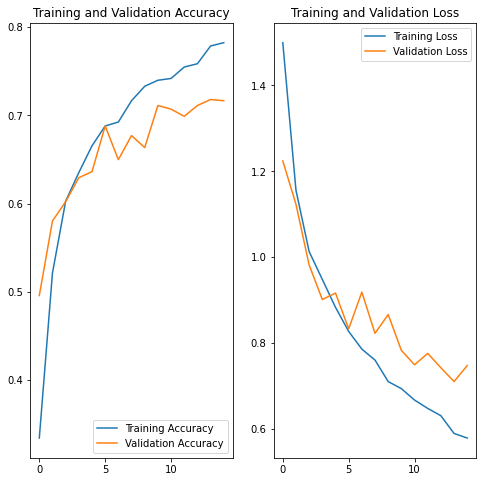

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

  8192/117948 [=>............................] - ETA: 0s

122880/117948 [===============================] - 0s 0us/step


This image most likely belongs to sunflowers with a 99.88 percent confidence.
